# **Testando algoritimos Eigenfaces e Fisherfaces em reconhecimento de imagens**

Neste trabalho, veremos algumas técnicas simples de reconhecimento de rostos. 



# **Banco de dados Jaffe**
A base de dados JAFFE consiste em 213 imagens de diferentes expressões faciais de 10 mulheres japonesas diferentes. Cada mulher foi solicitada a fazer 7 expressões faciais (6 expressões faciais básicas e neutras) 

As faces com a expressão neutra serão usadas como imagens de treinamento e as demais expressões serão usados como imagens de teste.

https://zenodo.org/record/3451524#.ZAYqcXbMLIU

## Pacotes que serão utilizados:

In [205]:

import os   # usado para interagir com o sistema operacional e no nosso caso para trabalhar com o nome e caminho da imagem
from string import digits # retorna os digitos '0123456789'
import pandas as pd    # biblioteca poderosa para manipulação e análise de dados 
import numpy as np
from PIL import Image #Abre e identifica o arquivo de imagem fornecido.
import cv2
from matplotlib import pyplot as plt  # usado para plotar as imagens
from sklearn import metrics #import classification_report, confusion_matrix,cohen_kappa_score

## **Lendo as imagens**

In [206]:
dirImage = './jaffe'  # diretório contendo as imagens
images_path = os.listdir(dirImage) # caminho da imagem
feelings = []                      # definindo vetor vazio para as emoçoes
pessoas=[]
for i, p in enumerate(images_path):
    images_path[i] = os.path.join(dirImage, p)   #  # Retorna uma lista de nomes das imagens
    remove_digits = str.maketrans('', '', digits)   # funçao que remove digitos
    feeling = p.split('.')[1].translate(remove_digits) # criando o vetor de emoçoes 
    pessoa = p.split('.')[0] 
    feelings.append(feeling) 
    pessoas.append(pessoa)  # cria um vetor que contem o nome da mulher
    
dados = pd.DataFrame({'caminho': images_path, 'emoção': feelings, 'InicialNome': pessoas})  # usando pandas para construir um dataframe
#dataframe será usado na proxima etapa que  irá separar as imagens por emoção.
print(dados)

                    caminho emoção InicialNome
0    ./jaffe\KA.AN1.39.tiff     AN          KA
1    ./jaffe\KA.AN2.40.tiff     AN          KA
2    ./jaffe\KA.AN3.41.tiff     AN          KA
3    ./jaffe\KA.DI1.42.tiff     DI          KA
4    ./jaffe\KA.DI2.43.tiff     DI          KA
..                      ...    ...         ...
208  ./jaffe\YM.SA2.56.tiff     SA          YM
209  ./jaffe\YM.SA3.57.tiff     SA          YM
210  ./jaffe\YM.SU1.58.tiff     SU          YM
211  ./jaffe\YM.SU2.59.tiff     SU          YM
212  ./jaffe\YM.SU3.60.tiff     SU          YM

[213 rows x 3 columns]


In [207]:
img = Image.open("./jaffe\KA.AN1.39.tiff")
print(np.array(img))

[[105 102 108 ... 126 136 132]
 [102 107 110 ... 132 134 133]
 [ 99 106 112 ... 132 137 134]
 ...
 [ 63  61  58 ... 126 129 138]
 [ 59  63  55 ... 115 122 139]
 [ 55  56  51 ... 119 113 119]]


In [208]:
##função que será usada para ler as imagens jaffe e separar de acordo com as emoçoes que serão usadas para teste
# escalar que se refere À dimensao se refere ao tamnho da imagem(altura ou largura)
def processamentoJaffe(data,dimensao):
    triste = []
    nojo = []
    raiva = []
    feliz = []
    medo = []
    surpreza = []
    neutro = []
    im = []
    #“an”,   “di”, “fe”,    “ha”,          ne         “sa”          “su”
    #raiva,  nojo, medo, felicidade, neutralidade, tristeza       surpresa
    
    dimensao=256 # dimensão de saida das imagens
    
    for i, row in data.iterrows():
        #convert('L') --> converte a imagem para greyscale
        img = Image.open(row['caminho']).convert('L').resize((dimensao,dimensao))    
                    # resize pode ser usado para reduzir ou aumentar a imagem
        img = np.array(img)
        im.append(img)
        feeling = row['emoção']
        if feeling == 'FE':
            medo.append(img)
        elif (feeling == 'HA'):
            feliz.append(img)
        elif (feeling == 'SA'):
            triste.append(img)
        elif (feeling == 'NE'):
            neutro.append(img)
        elif (feeling == 'SU'):
            surpreza.append(img)
        elif (feeling == 'DI'):
            nojo.append(img)
        elif (feeling == 'AN'):
            raiva.append(img)
            
    triste = np.array(triste)
    nojo = np.array(nojo)
    raiva = np.array(raiva)
    feliz = np.array(feliz)
    medo = np.array(medo)
    surpreza = np.array(surpreza)
    neutro = np.array(neutro)
    

    all_images = np.concatenate((triste, nojo , raiva, feliz, medo, surpreza, neutro))
    return im, triste, nojo , raiva, feliz, medo, surpreza, neutro ,all_images

## Chamando a função acima e atribunindo valor as variáveis

In [209]:
dimensao=256
im, triste, nojo , raiva, feliz, medo, surpreza, neutro ,all_images = processamentoJaffe(dados,dimensao)


In [210]:
dados= pd.DataFrame({'imagem': im, 'emocao': feelings, 'id': pessoas})
dados.head()

,imagem,emocao,id
0,"[[105, 102, 108, 118, 114, 117, 113, 122, 113,...",AN,KA
1,"[[114, 115, 116, 118, 118, 114, 113, 118, 116,...",AN,KA
2,"[[96, 98, 114, 103, 102, 103, 110, 104, 103, 1...",AN,KA
3,"[[109, 118, 102, 108, 119, 109, 114, 110, 109,...",DI,KA
4,"[[114, 118, 115, 114, 116, 107, 114, 120, 111,...",DI,KA


In [211]:
tabela = dados.groupby(['id','emocao']).size().unstack(1)


In [212]:
tabela.loc['Total',:]= tabela.sum(axis=0)
tabela.loc[:,'Total'] = tabela.sum(axis=1)
tabela

emocao,AN,DI,FE,HA,NE,SA,SU,Total
id,,,,,,,,
KA,3.0,3.0,4.0,4.0,3.0,3.0,3.0,23.0
KL,3.0,4.0,3.0,3.0,3.0,3.0,3.0,22.0
KM,3.0,2.0,3.0,4.0,3.0,4.0,3.0,22.0
KR,3.0,3.0,3.0,2.0,3.0,3.0,3.0,20.0
MK,3.0,3.0,3.0,3.0,3.0,3.0,3.0,21.0
NA,3.0,3.0,3.0,3.0,3.0,3.0,3.0,21.0
NM,3.0,2.0,3.0,3.0,3.0,3.0,3.0,20.0
TM,3.0,3.0,3.0,3.0,3.0,3.0,3.0,21.0
UY,3.0,3.0,3.0,3.0,3.0,3.0,3.0,21.0


## Trocando rótulos de id para usar as funções de treinamento

In [213]:

dados=dados.replace("KA",0)
dados=dados.replace("KL",1)
dados=dados.replace('KM',2)
dados=dados.replace("KR",3)
dados=dados.replace("MK",4)
dados=dados.replace("NA",5)
dados=dados.replace("NM",6)
dados=dados.replace("TM",7)
dados=dados.replace("UY",8)
dados=dados.replace("YM",9)


C:\Users\Usuario\anaconda3\envs\envname\lib\site-packages\pandas\core\missing.py:95: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  new_mask = arr == x


In [215]:
dados.head()

,imagem,emocao,id
0,"[[105, 102, 108, 118, 114, 117, 113, 122, 113,...",AN,0
1,"[[114, 115, 116, 118, 118, 114, 113, 118, 116,...",AN,0
2,"[[96, 98, 114, 103, 102, 103, 110, 104, 103, 1...",AN,0
3,"[[109, 118, 102, 108, 119, 109, 114, 110, 109,...",DI,0
4,"[[114, 118, 115, 114, 116, 107, 114, 120, 111,...",DI,0


 # Treinando o modelo

In [216]:
# digite a emoção de treinamento: 
emoção=["NE","HA"]   # preencha o espaço " " caso for treinar com 2 expressões. 
#Se for treinar com apenas uma expressão, pode deixar emoção=["NE",""]

#“AN”,     “DI”,    “FE”,    “HA”,          "NE"         “SA”          “SU”
#raiva,    nojo,    medo,   felicidade,   neutralidade, tristeza     surpresa


dados2 = dados[(dados["emocao"]==emoção[0]) | (dados["emocao"]==emoção[1])] # banco de dados apenas com a(s) espressão(es) de treinamento
#dados2 = dados
faces = np.array(dados2["imagem"])
ids = np.array(dados2["id"])


print(ids)

eigenface = cv2.face.EigenFaceRecognizer_create(9) #Função para usar o método eigenface
fisherface = cv2.face.FisherFaceRecognizer_create() #Função para usar o método fisherface

print("Treinando...")

classificadorEigen = eigenface.train(faces, ids)  # treinando o modelo
classificadorFisher = fisherface.train(faces, ids) 

print("Treinamento realizado")

[0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 4 5 5 5 5 5 5
 6 6 6 6 6 6 7 7 7 7 7 7 8 8 8 8 8 8 9 9 9 9 9 9]
Treinando...
Treinamento realizado


# Classificadores

In [197]:
#definindo Imagens de teste
teste = dados[dados["emocao"] !="NE"]  # tirando as emoções para usar como teste
teste = teste[teste["emocao"] !="HA"]

idteste= teste["id"].tolist()
imteste= teste["imagem"].tolist()

len(imteste)

152

In [220]:
def classificador(emocao,idreal):   # funçao que retorna os resultados
  
    predEigen=[]
    confEigen=[]
    predFisher=[]
    confFisher=[]


    for i in range(len(emocao)):
        resultado = eigenface.predict(emocao[i])
        predEigen.append(resultado[0])  # retorna o id predito
        confEigen.append(resultado[1])  

        resultado = fisherface.predict(emocao[i])
        predFisher.append(resultado[0])
        confFisher.append(resultado[1])



    predicao = pd.DataFrame({"idreal": idreal,'eigenpredic': predEigen, 'eigenconf': confEigen,
                            'fisherpredic': predFisher, 'fisherconf': confFisher})

    #print(predicao)
    
        #Matriz de confusao
    eigenMatrix=metrics.confusion_matrix(idreal,predEigen)
    fisherMatrix=metrics.confusion_matrix(idreal,predFisher)
    
    eigenresult= metrics.classification_report(idreal,predEigen)
    fisherresult= metrics.classification_report(idreal,predFisher)

    #print("\n  Eigenface  \n",eigenMatrix,"\n",metrics.classification_report(idreal,predEigen),
    #      "\n Fisherface \n",fisherMatrix,"\n",metrics.classification_report(idreal,predFisher))
    
    #print("acuracia",metrics.accuracy_score(idreal,predEigen)) # acuracia
    #print("precisao",metrics.balanced_accuracy_score(idreal,predEigen)) # Calcule a precisão balanceada.

    #print('\n')
    
    return eigenMatrix,fisherMatrix,eigenresult,fisherresult

In [223]:
# chamando o classificador
eigenMatrix,fisherMatrix,eigenresult,fisherresult=classificador(imteste,idteste)

## Resultados

In [200]:
tab = pd.DataFrame(eigenMatrix)
tab

,0,1,2,3,4,5,6,7,8,9
0,12,0,0,0,2,2,0,0,0,0
1,0,16,0,0,0,0,0,0,0,0
2,1,0,14,0,0,0,0,0,0,0
3,0,0,0,14,0,1,0,0,0,0
4,0,0,0,0,14,1,0,0,0,0
5,1,0,0,0,2,12,0,0,0,0
6,1,0,0,0,1,0,12,0,0,0
7,0,0,0,0,0,0,0,12,0,3
8,0,0,0,0,0,0,0,0,15,0
9,0,0,0,0,0,0,0,3,0,13


In [224]:
tab = pd.DataFrame(fisherMatrix)
tab

,0,1,2,3,4,5,6,7,8,9
0,16,0,0,0,0,0,0,0,0,0
1,0,16,0,0,0,0,0,0,0,0
2,0,0,15,0,0,0,0,0,0,0
3,0,0,0,15,0,0,0,0,0,0
4,0,0,0,0,14,1,0,0,0,0
5,0,0,0,0,0,15,0,0,0,0
6,0,0,0,0,0,0,13,0,1,0
7,0,0,0,0,0,0,0,12,0,3
8,0,0,0,0,0,0,0,0,15,0
9,0,0,0,0,0,0,0,0,0,16


In [201]:
print(eigenresult)


              precision    recall  f1-score   support

           0       0.80      0.75      0.77        16
           1       1.00      1.00      1.00        16
           2       1.00      0.93      0.97        15
           3       1.00      0.93      0.97        15
           4       0.74      0.93      0.82        15
           5       0.75      0.80      0.77        15
           6       1.00      0.86      0.92        14
           7       0.80      0.80      0.80        15
           8       1.00      1.00      1.00        15
           9       0.81      0.81      0.81        16

    accuracy                           0.88       152
   macro avg       0.89      0.88      0.88       152
weighted avg       0.89      0.88      0.88       152



## Cauculando a Sensibilidade e Especificidade

In [225]:
    emocao=imteste
    predEigen=[]
    predFisher=[]



    for i in range(len(emocao)):
        resultado = eigenface.predict(emocao[i])
        predEigen.append(resultado[0])  # retorna o id predito 

        resultado = fisherface.predict(emocao[i])
        predFisher.append(resultado[0])


In [227]:


y_true=idteste
y_pred=predFisher   # trocar pelo valor predito
#y_pred=predEigen   

labels=[0,1,2,3,4,5,6,7,8,9]

from sklearn.metrics import precision_recall_fscore_support

result=[]
for label in labels:
    precision, recall, f_score, support = precision_recall_fscore_support(np.array(y_true)==label,np.array(y_pred)==label)
    result.append([label,recall[0],recall[1],precision[1],f_score[1],support[1]])
df=pd.DataFrame(result,columns=["label","specificity","recall","precision","f_score","support"])
print(df.round(4))

print("======================================================")

print("acuracia",metrics.accuracy_score(idteste,y_pred).round(4)) # acuracia

w=df["support"]/df["support"].sum()
df_summary=df[["specificity","recall","precision","f_score"]].apply(lambda col:np.sum(col*w),axis=0)
print(df_summary.round(4))

print("======================================================")



   label  specificity  recall  precision  f_score  support
0      0       1.0000  1.0000     1.0000   1.0000       16
1      1       1.0000  1.0000     1.0000   1.0000       16
2      2       1.0000  1.0000     1.0000   1.0000       15
3      3       1.0000  1.0000     1.0000   1.0000       15
4      4       1.0000  0.9333     1.0000   0.9655       15
5      5       0.9927  1.0000     0.9375   0.9677       15
6      6       1.0000  0.9286     1.0000   0.9630       14
7      7       1.0000  0.8000     1.0000   0.8889       15
8      8       0.9927  1.0000     0.9375   0.9677       15
9      9       0.9779  1.0000     0.8421   0.9143       16
acuracia 0.9671
specificity    0.9962
recall         0.9671
precision      0.9710
f_score        0.9668
dtype: float64


 # Normalização e cálculo de componentes principais de forma manual

In [228]:
#images = np.concatenate((neutro,feliz))
images = neutro

images = images.transpose(1,2,0)
images = images/255
print(images.shape)

M = images.shape[2] #samples
N = images.shape[0] #Dimension
mean = np.mean(images, axis = 2)
demeaned = images - mean[...,None] # Subtract average face from all faces.
demeaned.shape

(256, 256, 30)


(256, 256, 30)

In [229]:
demeaned[3]

array([[ 0.08509804,  0.08509804,  0.02235294, ...,  0.01843137,
        -0.05607843,  0.0027451 ],
       [ 0.08928105,  0.10104575,  0.03045752, ..., -0.0048366 ,
        -0.05581699, -0.0048366 ],
       [ 0.09254902,  0.09647059, -0.01333333, ...,  0.00235294,
        -0.03294118, -0.03294118],
       ...,
       [ 0.05320261,  0.07281046, -0.02522876, ...,  0.02183007,
        -0.01738562,  0.0296732 ],
       [ 0.04732026,  0.03947712, -0.0075817 , ..., -0.01150327,
         0.00418301,  0.03555556],
       [ 0.0379085 ,  0.06143791,  0.00261438, ...,  0.00653595,
        -0.01699346,  0.02222222]])

(-0.5, 255.5, 255.5, -0.5)

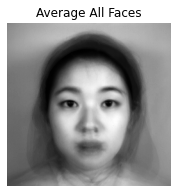

In [230]:
plt.figure(figsize=(3,3))
plt.imshow(mean, cmap = 'gray')
plt.title('Average All Faces')
plt.axis('off')

In [231]:
from numpy import linalg
def compute_eigenface(demeaned):
    dem_flat = np.zeros((N*N, M))
    for i in range(M):
        dem_flat[:,i] = demeaned[:,:,i].flatten()

    L = np.matmul(dem_flat.transpose(), dem_flat)
    mu, v = linalg.eig(L)  #Calcula os autovalores e os autovetores à direita de uma matriz quadrada.
    idx = mu.argsort()[::-1]
    mu = mu[idx]
    v = v[:,idx]
    u = np.matmul(dem_flat, v)
    return mu,v,u

In [232]:
mu,v,u = compute_eigenface(demeaned)

eigfaces = np.zeros((N,N,M))#64,64,213
for i in range(M):
    eigfaces[:,:,i] = u[:,i].reshape(N,N)
    
fig = plt.figure(figsize=(100, 100))
for i in range(30):
    plt.subplot(7,5,i+1)
    plt.imshow(eigfaces[:,:,i],cmap = 'gray')
    plt.axis('off')
plt.suptitle('All eigenfaces' ,size=213)

# Escolhendo o número de componentes 

In [247]:
autovalores = eigenface.getEigenValues()
#autovalores = fisherface.getEigenValues()

In [248]:
autovalores

array([[20292451.70310924],
       [18219900.69737743],
       [12066696.38907869],
       [ 5867529.86815644],
       [ 4717292.2295335 ],
       [ 3871184.47424274],
       [ 3386280.42022061],
       [ 3060361.48591378],
       [ 2090724.26303776]])

In [249]:
#usado para o fisherfaces
#autovalores=np.array([[1.94049825e+05], [8.43722968e+03], [2.82873031e+03], [2.62786940e+03],
#        [7.00004068e+02], [4.69067661e+02], [3.02929506e+02], [1.35830216e+02],  [9.07643171e+01]])

In [250]:
autovalores

array([[20292451.70310924],
       [18219900.69737743],
       [12066696.38907869],
       [ 5867529.86815644],
       [ 4717292.2295335 ],
       [ 3871184.47424274],
       [ 3386280.42022061],
       [ 3060361.48591378],
       [ 2090724.26303776]])

In [251]:
def compute_cum(autovalores):    #função para calcular o a variancia acumulada
    total_var = sum(autovalores)
    cum_var = np.cumsum(autovalores)/total_var
    num_comp = range(1,len(autovalores)+1)
    return cum_var, num_comp

In [252]:
sum(autovalores)

array([73572421.5306702])

In [253]:
cum_var, num_comp = compute_cum(autovalores)

In [254]:
cum_var

array([0.27581601, 0.5234618 , 0.68747294, 0.76722469, 0.83134236,
       0.8839597 , 0.92998619, 0.97158277, 1.        ])

In [255]:
num_comp

range(1, 10)

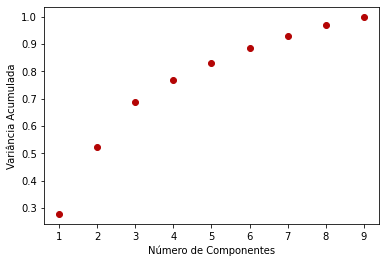

In [256]:
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Acumulada')

#plt.figure(dpi=150)
plt.scatter(num_comp, cum_var,color='#b40505')
#plt.axvline(x = 9,color = 'black',linewidth=0.5)
plt.show() #Exibir todas as figuras abertas.


In [257]:
tab=pd.DataFrame(num_comp,cum_var)
plt.show()
tab

,0
0.275816,1
0.523462,2
0.687473,3
0.767225,4
0.831342,5
0.883960,6
0.929986,7
0.971583,8
1.000000,9
